# **XGB-DQN**

# S0 Preparation
### **S0** 准备工作

Before running the code, make sure to perform the following preparation steps.
- [x] Install Anaconda
- [x] Create a new environment
- [x] Install the following Python packages in the new environment: numpy, pandas, tensorflow, xgboost, scikit-learn, scikit-optimize, ...
- [x] Run Jupyter Lab in the new environment
- [x] Navigate to this file by double-clicking on it in the file directory on the left side of Jupyter Lab 
- [x] Choose the kernel of the new environment in the top right corner of Jupyter Lab

在运行代码前，请确保完成以下准备工作：
- [x] 安装Anaconda
- [x] 创建一个新的环境
- [x] 在新环境安装以下python包：numpy, pandas, tensorflow, xgboost, scikit-learn, scikit-optimize ...
- [x] 在新环境下运行jupyter lab
- [x] 在jupyter左侧的文件夹目录下找到本文件并双击打开
- [x] 在jupyter右上角选择新环境的kernel

## **1** Importing Python Packages

In [1]:
#导入常用的库
import pandas as pd 
import numpy as np
from numpy import loadtxt
import random
import tensorflow as tf
import xgboost as xgb # 1.5.0
from skopt import BayesSearchCV 
from skopt.space import Integer
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

/Users/user/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-10-28 11:35:30.261079: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2 Preparing Data ##

In [2]:
# 1. Read the processed CSV file, modify the file paths based on your actual file locations
# 1.读取处理后的csv文件，根据您的文件保存路径进行修改
xgb_file = "Cleaned_data.csv"
xgb_encode_file = "Cleaned_data_encode.csv"

# 2. Read the data 3. Set the timestamp format # 4. Remove missing values
# 2. 读取数据  3. 设定时间戳格式  4. 删除缺失值
data = pd.read_csv(xgb_file,encoding='gbk')
data['Date_Time'] = pd.to_datetime(data['Date_Time'])
data = data.dropna()
data = data[data != -999].dropna()
# data.head()

# 5. Encode non-numeric variables
# 5. 将非数值类型的变量进行编码 
dtypes_list=data.dtypes.values
columns_list=data.columns
for i in range(len(columns_list)):
    if dtypes_list[i]=='object':
        lb=LabelEncoder()
        lb.fit(data[columns_list[i]])
        data[columns_list[i]]=lb.transform(data[columns_list[i]])
data.head()

# data.to_csv(xgb_encode_file,index=False)

,ID,Date_Time,AC_Status,Window_Status,CLast_Time,CLast_Time_T,WLast_Time,WLast_Time_T,Indoor_Temp,Indoor_RH,...,Room_ID,Study_ID,City,Next_Indoor_Temp,Next_Indoor_RH,Next_Outdoor_Temp,Next_Outdoor_RH,Differ_Outdoor_Temp,Differ_Indoor_Temp,Target_Temp
0,1,2019-03-05 00:00:00,0,0.0,0,0,0.0,0.0,25.12,70.84,...,0,6,0,25.09,71.22,26.0,84.0,0.0,-0.03,0.0
1,2,2019-03-05 01:00:00,0,0.0,0,0,0.0,0.0,25.09,71.22,...,0,6,0,25.05,71.66,26.0,89.0,0.0,-0.04,0.0
2,3,2019-03-05 02:00:00,0,0.0,0,0,0.0,0.0,25.05,71.66,...,0,6,0,25.02,71.84,26.0,89.0,0.0,-0.03,0.0
3,4,2019-03-05 03:00:00,0,0.0,0,0,0.0,0.0,25.02,71.84,...,0,6,0,24.97,72.11,25.0,89.0,-1.0,-0.05,0.0
4,5,2019-03-05 04:00:00,0,0.0,0,0,0.0,0.0,24.97,72.11,...,0,6,0,24.92,72.12,25.0,89.0,0.0,-0.05,0.0


## 3 Training the XGBoost Model

In [3]:
# 7. 'x' represents independent variables, 'y' represents the feature to be predicted
x = data.drop(['Next_Indoor_Temp','Next_Indoor_RH','Date_Time','Study_ID','Differ_Indoor_Temp','ID'],axis=1)
y = data['Differ_Indoor_Temp']

# 8. Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=2022)

In [5]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 5), 
                    'n_estimators': Integer(100, 500), 
                    'learning_rate': (0.1, 0.5)},
                    random_state=2022,
                    scoring='r2',
                    n_iter=20,
                    cv=3)
opt.fit(x_train, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('learning_rate', 0.23474256920263026), ('max_depth', 5), ('n_estimators', 500)])


In [4]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=5, 
                            learning_rate=0.23474, 
                            n_estimators=500)
model_XGB.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.23474, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

## 3 DQN Framework

In [5]:
# Create Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

# DQN
@tf.keras.saving.register_keras_serializable()
class DQN(tf.keras.Model):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_actions, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)
        
# Create Deep Q-Network (DQN) Model
def update_Q_network(batch_size, replay_buffer, Q_network, gamma, num_actions, loss_function, optimizer):
    states, actions, next_states, rewards = zip(*replay_buffer.sample(batch_size))
    states = np.array(states)
    actions = np.array(actions)
    next_states = np.array(next_states)
    rewards = np.array(rewards)

    with tf.GradientTape() as tape:
        Q_values = Q_network(states)
        target_Q_values = Q_network(next_states)
        target_Q_values = rewards + gamma * tf.reduce_max(target_Q_values, axis=1)
        mask = tf.one_hot(actions, num_actions)
        Q_action = tf.reduce_sum(tf.multiply(Q_values, mask), axis=1)
        loss = loss_function(target_Q_values, Q_action)

    grads = tape.gradient(loss, Q_network.trainable_variables)
    optimizer.apply_gradients(zip(grads, Q_network.trainable_variables))

# Create Target Network Update Function
def update_target_network(target_network, Q_network):
    target_network.set_weights(Q_network.get_weights())

# Create ε-Greedy Policy
def epsilon_greedy_policy(state, epsilon, num_actions, Q_network):
    if np.random.rand() < epsilon:
        return np.random.randint(num_actions)
    else:
        Q_values = Q_network(np.array([state]))
        return np.argmax(Q_values)
        
# Define Reward Function
def calculate_reward(state, step, action, next_state, energy_weight=1):
    reward = 0
    standard = 'ASHRAE'
    coordinates_dict = {'ASHRAE': [[17.4, 18.4, 23.4, 24.4], [23.6, 24.6, 29.6, 30.6], [10, 30]]}
    L11, L12, U12, U11 = coordinates_dict[standard][0]
    L21, L22, U22, U21 = coordinates_dict[standard][1]
    T1, T2 = coordinates_dict[standard][2]
    InT, OutT = next_state[0], next_state[2]
    if OutT <= T1:
        L1, L2, U2, U1 = L11, L12, U12, U11
    elif OutT >= T2:
        L1, L2, U2, U1 = L21, L22, U22, U21
    else:
        increase = (OutT-T1)*(L21-L11)/(T2-T1)
        L1, L2, U2, U1 = L11+increase, L12+increase, U12+increase, U11+increase
    if InT>=L2 and InT<=U2:
        reward = 0
    elif InT<L2:
        reward = -60 * ((InT-L2) ** 2)
    elif InT>U2:
        reward = -60 * ((InT-U2) ** 2)
    if action==0 or action==12:
        reward = reward+0
    elif action>12:
        reward = reward-(2*(60*0.87*1)*energy_weight)
    else:
        reward = reward-((60*0.87*1)*energy_weight)
    return reward
    
# Establish Mapping between Actions and Index
def map_action_to_dataframe(action):
    Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = 0,0,0,0,0
    action = int(action)
    if action == 0:
        Target_Temp = 0
        AC_Status = 0
        CLast_Time = 0
        Window_Status = 0
        WLast_Time = 0
    elif action>0 and action<12:
        Target_Temp = 19 + action
        AC_Status = 1
        CLast_Time = 60
        Window_Status = 0
        WLast_Time = 0
    elif action == 12:
        Target_Temp = 0
        AC_Status = 0
        CLast_Time = 0
        Window_Status = 1
        WLast_Time = 60
    else:
        Target_Temp = action+7
        AC_Status = 1
        CLast_Time = 60
        Window_Status = 1
        WLast_Time = 60
    return Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time

In [5]:
# Filter Data for One Day
def choose_data(a,data):
    data_test00 = data[a:a+23]
    data_test0a = data_test00.reset_index(drop=True) # 备份
    data_test0 = data_test00.reset_index(drop=True)
    new_time_c = data_test0a.iloc[0]['CLast_Time_T'] - data_test0a.iloc[0]['AC_Status']*60
    data_test0.at[0,'CLast_Time_T'] = new_time_c
    new_time_w = data_test0a.iloc[0]['WLast_Time_T'] - data_test0a.iloc[0]['Window_Status']*60
    data_test0.at[0,'WLast_Time_T'] = new_time_w
    data_test = data_test0[['Indoor_Temp','Indoor_RH','Outdoor_Temp','Outdoor_RH','Rain','Cloud','Windspeed','Hour','Next_Outdoor_Temp','Next_Outdoor_RH']].copy()
    xgboost_test = data_test0.drop(['Next_Indoor_Temp','Next_Indoor_RH','Date_Time','Study_ID','Differ_Indoor_Temp','ID'],axis=1)
    return data_test,xgboost_test

## 4 Prepare RL Data ##

In [6]:
def get_week_data_of_city(data, city, start_date, end_date):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    city_encode_mapping = {"Florianopolis":0, "Nanjing": 1 , "Rende": 2 , "Sao Paulo": 3 }
    data['Date'] = pd.to_datetime(data['Date_Time'].dt.date)
    city_data = data[data['City'] == city_encode_mapping[city]]
    city_week_data = city_data[(city_data['Date'] >= start_date) & (city_data['Date'] <= end_date)]
    city_week_data = city_week_data.drop(columns=['Date'])
    rooms = city_week_data['Room_ID'].unique()
    if len(rooms)  > 1:
        print(len(rooms))
        print("Too many rooms. Sampling one room only")
        chosen_room = rooms[1]
        city_week_data = city_week_data[city_week_data['Room_ID'] == chosen_room]

    # Identify and drop duplicate rows
    columns_to_check = city_week_data.columns.difference(['ID'])
    duplicates = city_week_data.duplicated(subset=columns_to_check, keep=False)
    df_cleaned = city_week_data.drop_duplicates(subset=columns_to_check)

    return df_cleaned

In [7]:
city_dates_mapping = {"Nanjing": ["2016-09-06", "2016-09-12"], "Rende": ["2016-07-25", "2016-07-31"], "Florianopolis": ["2020-02-15", "2020-02-21"], "Sao Paulo": ["2017-10-03", "2017-10-09"]}

nanging_data_week = get_week_data_of_city(data, "Nanjing", *city_dates_mapping["Nanjing"])
rende_data_week = get_week_data_of_city(data, "Rende", *city_dates_mapping["Rende"])
flori_data_week = get_week_data_of_city(data, "Florianopolis", *city_dates_mapping["Florianopolis"])
sau_paulo_data_week = get_week_data_of_city(data, "Sao Paulo", *city_dates_mapping["Sao Paulo"])

3
Too many rooms. Sampling one room only


## 5 Train XGB-DQN Model ##

### 5.1 Train model AND select best policy immediately

In [18]:
# Define Parameters
# 定义参数
num_features = 8
num_actions = 24
gamma = 0.9  # Discount factor 折扣因子
epsilon = 1.0  # Initial exploration rate 初始探索率
min_epsilon = 0.1  # Minimum exploration rate 最小探索率
epsilon_decay = 0.995  # Exploration rate decay factor 探索率衰减因子，ε-greedy策略中的ε
learning_rate = 0.001  # Learning rate 学习率，通常选择0.001有利于收敛
memory_capacity = 10000  # Experience replay buffer capacity 经验回放缓冲区容量
batch_size = 32  # Batch size 批量处理大小

In [19]:
episode_list = []
training_total_reward_list = []
best_policy = []
best_policy_next_in_temp_list = []
best_policy_AC_Status_List=[]
best_policy_W_Status_List=[]
best_policy_total_reward_list = []

data_RL = nanging_data_week # pd.concat([nanging_data_week, rende_data_week, flori_data_week, sau_paulo_data_week], ignore_index=True)



# Create Q-Network and Target Network
Q_network = DQN(num_actions)
target_network = DQN(num_actions)

# Define Loss Function and Optimizer
loss_function = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.Adam(learning_rate)

for i in range(0,7):
    
    # Create Experience Replay Buffer
    replay_buffer = ReplayBuffer(memory_capacity)
    epsilon = 1.0  # Initial exploration rate per day 初始探索率

    # Train DQN
    data_test,xgboost_test = choose_data(i*24,data_RL)
    num_episodes = 1000
    for episode in range(num_episodes):
        episode_list.append(episode)
        data_pre_test = data_test
        xgboost_pre_test = xgboost_test
        total_reward = 0
        for step in range(6):
            xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        state = data_pre_test.iloc[6, :num_features].values  # 开始工作的初始始状态   
        for step in range(6,18):
            action = epsilon_greedy_policy(state, epsilon, num_actions, Q_network)
            Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
            xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
            xgboost_pre_test.at[step,'AC_Status'] = AC_Status
            xgboost_pre_test.at[step,'Window_Status'] = Window_Status
            xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
            xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
            if CLast_Time > 0:
                xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
            else:
                xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
            if WLast_Time > 0:
                xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
            else:
                xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_state = data_pre_test.iloc[step+1, :num_features].values           
            reward = calculate_reward(state,step, action, next_state)
            total_reward += reward
            replay_buffer.push(state, action, next_state, reward)
            state = next_state
            if epsilon > min_epsilon:
                    epsilon *= epsilon_decay
            if len(replay_buffer.memory) >= batch_size:
                update_Q_network(batch_size, replay_buffer, Q_network, gamma, num_actions, loss_function, optimizer)
        training_total_reward_list.append(total_reward)
        
    # Training Completed, Make Decisions    
    data_pre_test = data_test
    xgboost_pre_test = xgboost_test
    total_best_policy_reward = 0
    for step in range(0,6):
        if step ==0:
            temp_original = data_pre_test.iloc[step]['Indoor_Temp']
            best_policy_next_in_temp_list.append(temp_original)
        best_policy.append(0)
        best_policy_AC_Status_List.append(0)
        best_policy_W_Status_List.append(0)
        xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
        hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
        next_differ_temp_list = model_XGB.predict(hour_row_df) 
        next_differ_temp = next_differ_temp_list[0]
        next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
        xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        best_policy_next_in_temp_list.append(next_in_temp)
        data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
    state = data_pre_test.iloc[6, :num_features].values
    for step in range(6,18):
        action = epsilon_greedy_policy(state, 0, num_actions, Q_network)
        Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
        best_policy.append(action)
        best_policy_AC_Status_List.append(AC_Status)
        best_policy_W_Status_List.append(Window_Status)
        xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
        xgboost_pre_test.at[step,'AC_Status'] = AC_Status
        xgboost_pre_test.at[step,'Window_Status'] = Window_Status
        xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
        xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
        if CLast_Time > 0:
            xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
        else:
            xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
        if WLast_Time > 0:
            xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
        else:
            xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
        hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
        next_differ_temp_list = model_XGB.predict(hour_row_df) 
        next_differ_temp = next_differ_temp_list[0]
        next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
        xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        best_policy_next_in_temp_list.append(next_in_temp)
        data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        next_state = data_pre_test.iloc[step+1, :num_features].values
        reward = calculate_reward(state,step, action, next_state)
        total_best_policy_reward += reward      
        state = next_state
    for step in range(18,23):
        best_policy.append(0)
        best_policy_AC_Status_List.append(0)
        best_policy_W_Status_List.append(0)
        xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
        hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
        next_differ_temp_list = model_XGB.predict(hour_row_df) 
        next_differ_temp = next_differ_temp_list[0]
        next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
        xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        best_policy_next_in_temp_list.append(next_in_temp)
        data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
    best_policy.append(0)  
    best_policy_AC_Status_List.append(0)
    best_policy_W_Status_List.append(0)
    best_policy_total_reward_list.append(total_best_policy_reward)  
    
    print(best_policy[(i)*24:(i+1)*24])
    print(best_policy_next_in_temp_list[(i)*24:(i+1)*24])

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[29.7, 29.59164111763239, 29.371042688190936, 29.29376123547554, 29.244282887130975, 29.022986785322427, 28.7867736376822, 23.195633367449044, 23.326347694545984, 23.43239905759692, 23.62821968719363, 23.839725904911756, 24.039550372213125, 24.2083068870008, 24.257536117732524, 24.536323879659175, 24.586932976543903, 24.78882264047861, 24.952895094454288, 24.88776123970747, 24.980085265636443, 24.984378193784504, 25.0023923211731, 24.994116703327744]
[0, 0, 0, 0, 0, 0, 3, 0, 0, 12, 12, 0, 12, 12, 12, 12, 12, 12, 0, 0, 0, 0, 0, 0]
[28.9, 28.684399569034575, 28.50103864967823, 28.380494908988474, 28.29739218354225, 28.19477899521589, 28.173810362443326, 24.76028048954904, 24.830841064080595, 24.85530264265835, 25.29079956896603, 25.815756033733486, 26.195691864565013, 26.351011659577487, 26.69081860370934, 26.858121182397007, 26.941321793571113, 26.999578550085424, 26.898800156638025, 26.72137153856456, 26.663646090

### 5.2 Save Trained model and Results

In [21]:
import os
import pickle
def save_experiment_results(exp_name, Q_network, training_total_reward_list, best_policy, best_policy_next_in_temp_list, best_policy_AC_Status_List, best_policy_W_Status_List, best_policy_reward_list, description=None):
    dir_name = f"results_{exp_name}"
    
    # Create the directory if it does not exist
    if os.path.exists(dir_name):
        raise Exception("This directory already exist. To avoid overriding it, remove it manually only if you are sure")
    
    os.makedirs(dir_name)

    # Define the file paths
    q_network_path = os.path.join(dir_name, "Q_network.pkl")
    reward_list_path = os.path.join(dir_name, "training_total_reward_list.pkl")
    best_policy_path = os.path.join(dir_name, "best_policy.pkl")
    best_policy_next_in_temp_list_path = os.path.join(dir_name, "best_policy_next_in_temp_list.pkl")
    best_policy_AC_Status_List_path = os.path.join(dir_name, "best_policy_AC_Status_List.pkl")
    best_policy_W_Status_List_path = os.path.join(dir_name, "best_policy_W_Status_List.pkl")
    best_policy_reward_list_path = os.path.join(dir_name, "best_policy_reward_list.pkl")
    
    with open(q_network_path, 'wb') as q_file:
        pickle.dump(Q_network, q_file)
    
    with open(reward_list_path, 'wb') as reward_file:
        pickle.dump(training_total_reward_list, reward_file)

    with open(best_policy_path, 'wb') as best_policy_file:
        pickle.dump(best_policy, best_policy_file)
    
    with open(best_policy_next_in_temp_list_path, 'wb') as next_in_temp_file:
        pickle.dump(best_policy_next_in_temp_list, next_in_temp_file)

    with open(best_policy_AC_Status_List_path, 'wb') as AC_file:
        pickle.dump(best_policy_AC_Status_List, AC_file)

    with open(best_policy_W_Status_List_path, 'wb') as W_file:
        pickle.dump(best_policy_W_Status_List, W_file)

    with open(best_policy_reward_list_path, 'wb') as best_reward_file:
        pickle.dump(best_policy_reward_list, best_reward_file)

    if description is not None:
        description_path = os.path.join(dir_name, "description.txt")
        with open(description_path, 'w') as desc_file:
            desc_file.write(description)       

    print(f"Results saved in directory: {dir_name}")      

In [22]:
description = "Nanjing sample data week. 1000 episodes per day. all parameters are default"
save_experiment_results("nanjing_sample_week_1", Q_network, training_total_reward_list, best_policy, best_policy_next_in_temp_list, best_policy_AC_Status_List, best_policy_W_Status_List, best_policy_total_reward_list, description)

Results saved in directory: results_nanjing_sample_week_1


### 5.3 Generate new policy from the final trained model

### 5.4 Load Train Model and Results

In [45]:
def load_experiment_results(exp_name):
    dir_name = f"results_{exp_name}"

    # Get the file paths
    q_network_path = os.path.join(dir_name, "Q_network.pkl")
    reward_list_path = os.path.join(dir_name, "training_total_reward_list.pkl")
    best_policy_path = os.path.join(dir_name, "best_policy.pkl")
    best_policy_next_in_temp_list_path = os.path.join(dir_name, "best_policy_next_in_temp_list.pkl")
    best_policy_AC_Status_List_path = os.path.join(dir_name, "best_policy_AC_Status_List.pkl")
    best_policy_W_Status_List_path = os.path.join(dir_name, "best_policy_W_Status_List.pkl")
    best_policy_reward_list_path = os.path.join(dir_name, "best_policy_reward_list.pkl")
    
    # with open(q_network_path, 'rb') as q_file:
    #     Q_network = pickle.load(q_file)
    
    with open(reward_list_path, 'rb') as reward_file:
        training_total_reward_list = pickle.load(reward_file)

    with open(best_policy_path, 'rb') as best_policy_file:
        best_policy = pickle.load(best_policy_file)
    
    with open(best_policy_next_in_temp_list_path, 'rb') as next_in_temp_file:
        best_policy_next_in_temp_list = pickle.load(next_in_temp_file)

    with open(best_policy_AC_Status_List_path, 'rb') as AC_file:
        best_policy_AC_Status_List = pickle.load(AC_file)

    with open(best_policy_W_Status_List_path, 'rb') as W_file:
        best_policy_W_Status_List = pickle.load(W_file)

    with open(best_policy_reward_list_path, 'rb') as best_reward_file:
        best_policy_reward_list = pickle.load(best_reward_file)

    # return Q_network, 
    return training_total_reward_list, best_policy, best_policy_next_in_temp_list, best_policy_AC_Status_List, best_policy_W_Status_List, best_policy_reward_list



In [13]:
import os
import pickle

In [53]:
training_total_reward_list, best_policy, best_policy_next_in_temp_list, best_policy_AC_Status_List, best_policy_W_Status_List, best_policy_reward_list = load_experiment_results("nanjing_sample_week_1")

## 6. Analyse Convergence - X episodes per day ##

In [15]:
import matplotlib.pyplot as plt

def plot_chronological_reward(num_days, training_total_reward_list, exp_name):
    
    title=f"Reward per episode chronologically: {exp_name}" if exp_name else "Reward per episode chronologically"
    # Plotting the array with dots
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(training_total_reward_list)), training_total_reward_list, label='Reward per Episode', marker='o')
    plt.xlabel('Episode')
    
    # Adding x-axis ticks
    x_ticks = list(range(0, len(training_total_reward_list), len(training_total_reward_list)//num_days))
    x_labels = [f'Day {i+1}' for i in range(num_days)]
    plt.xticks(x_ticks, x_labels)

    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_mean_reward_per_episode(mean_reward_arr, exp_name):
    # Plotting the array with dots
    title=f"Mean Reward per Episode: {exp_name}" if exp_name else "Mean Reward per Episode"
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(mean_reward_arr)), mean_reward_arr, label='Mean Reward per Episode', marker='o')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    

def analyse_convergence_x_episodes_per_day(num_days, num_episodes_per_day, training_total_reward_list, dir_name=None, exp_name=""):
    daily_reward_dict = {i: training_total_reward_list[i*num_episodes_per_day:(i+1)*num_episodes_per_day] for i in range(num_days)}
    
    mean_reward_arr  = []
    for episode in range(num_episodes_per_day):
        mean_reward = sum([daily_reward_dict[day][episode] for day in range(num_days)]) / num_days
        mean_reward_arr.append(mean_reward)

    if dir_name is not None:
        daily_reward_dict_path = os.path.join(dir_name, "daily_reward_dict.pkl")
        mean_reward_arr_path = os.path.join(dir_name, "mean_reward_arr.pkl")
        with open(daily_reward_dict_path, 'wb') as dict_file:
            pickle.dump(daily_reward_dict, dict_file)
        with open(mean_reward_arr_path, 'wb') as arr_file:
            pickle.dump(daily_reward_dict, arr_file)
    
    
    plot_chronological_reward(num_days, training_total_reward_list, exp_name)
    plot_mean_reward_per_episode(mean_reward_arr, exp_name)
    
    

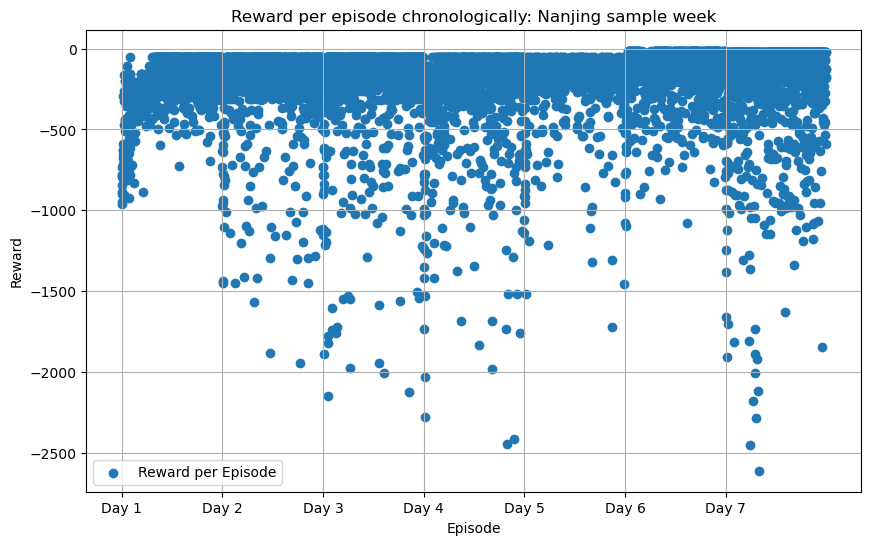

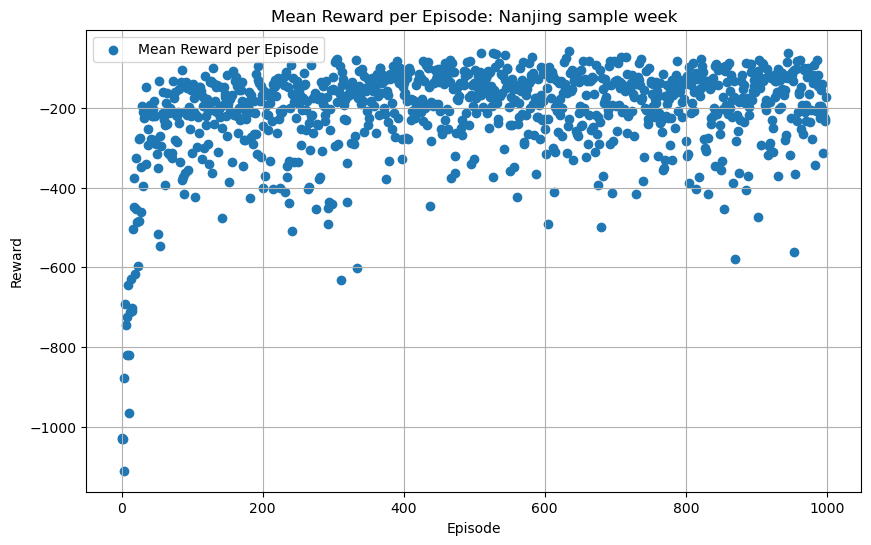

In [38]:
num_days = 7 # 28 for all sample weeks together
num_episodes_per_day=1000
exp_name="Nanging Sample Week"

analyse_convergence_x_episodes_per_day(num_days, num_episodes_per_day, training_total_reward_list, "results_nanjing_sample_week", "Nanjing sample week")


## 7. Calculate policy by final model after training on all data

In [16]:
# Training Completed, Make Decisions    
def create_policy_from_model(data, num_days, Q_network, num_actions):
    best_policy_final_model = []
    next_in_temp_list_final_model = []
    AC_Status_List_final_model=[]
    W_Status_List_final_model=[]
    best_policy_reward_list_final_model = []
    for i in range(num_days):
            data_test,xgboost_test = choose_data(i*24,data)    
            data_pre_test = data_test
            xgboost_pre_test = xgboost_test
            total_best_policy_reward = 0
            for step in range(0,6):
                if step ==0:
                    temp_original = data_pre_test.iloc[step]['Indoor_Temp']
                    next_in_temp_list_final_model.append(temp_original)
                best_policy_final_model.append(0)
                AC_Status_List_final_model.append(0)
                W_Status_List_final_model.append(0)
                xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
                hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
                next_differ_temp_list = model_XGB.predict(hour_row_df) 
                next_differ_temp = next_differ_temp_list[0]
                next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
                xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                next_in_temp_list_final_model.append(next_in_temp)
                data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            state = data_pre_test.iloc[6, :num_features].values
            for step in range(6,18):
                action = epsilon_greedy_policy(state, 0, num_actions, Q_network)
                Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
                best_policy_final_model.append(action)
                AC_Status_List_final_model.append(AC_Status)
                W_Status_List_final_model.append(Window_Status)
                xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
                xgboost_pre_test.at[step,'AC_Status'] = AC_Status
                xgboost_pre_test.at[step,'Window_Status'] = Window_Status
                xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
                xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
                if CLast_Time > 0:
                    xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
                else:
                    xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
                if WLast_Time > 0:
                    xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
                else:
                    xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
                hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
                next_differ_temp_list = model_XGB.predict(hour_row_df) 
                next_differ_temp = next_differ_temp_list[0]
                next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
                xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                next_in_temp_list_final_model.append(next_in_temp)
                data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                next_state = data_pre_test.iloc[step+1, :num_features].values
                reward = calculate_reward(state,step, action, next_state)
                total_best_policy_reward += reward      
                state = next_state
            for step in range(18,23):
                best_policy_final_model.append(0)
                AC_Status_List_final_model.append(0)
                W_Status_List_final_model.append(0)
                xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
                hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
                next_differ_temp_list = model_XGB.predict(hour_row_df) 
                next_differ_temp = next_differ_temp_list[0]
                next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
                xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                next_in_temp_list_final_model.append(next_in_temp)
                data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            best_policy_final_model.append(0)  
            AC_Status_List_final_model.append(0)
            W_Status_List_final_model.append(0)
            best_policy_reward_list_final_model.append(total_best_policy_reward)  

            print(best_policy_final_model[(i)*24:(i+1)*24])
            print(next_in_temp_list_final_model[(i)*24:(i+1)*24])
    return best_policy_final_model, next_in_temp_list_final_model, AC_Status_List_final_model, W_Status_List_final_model, best_policy_reward_list_final_model


In [21]:
best_policy_final_model, next_in_temp_list_final_model, AC_Status_List_final_model, W_Status_List_final_model, best_policy_reward_list_final_model = create_policy_from_model(nanging_data_week, 7, Q_network, num_actions)

[0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 12, 0, 0, 5, 12, 12, 12, 12, 0, 0, 0, 0, 0, 0]
[29.7, 29.59164111763239, 29.371042688190936, 29.29376123547554, 29.244282887130975, 29.022986785322427, 28.7867736376822, 27.13972397223115, 27.16036598831415, 27.15885267353151, 27.196077852905727, 27.33913142925594, 27.46840475446079, 27.439374971599317, 25.202846098155714, 25.476481306762434, 25.532698075682855, 25.721089746267534, 25.712844640412367, 25.668861952074803, 25.776827905722893, 25.763589376979507, 25.78006991597358, 25.770260719046927]
[0, 0, 0, 0, 0, 0, 4, 5, 12, 12, 12, 12, 12, 12, 12, 12, 12, 9, 0, 0, 0, 0, 0, 0]
[28.9, 28.684399569034575, 28.50103864967823, 28.380494908988474, 28.29739218354225, 28.19477899521589, 28.173810362443326, 25.89767301045358, 25.587767779454587, 25.6448806297034, 26.043735183402895, 26.436780757829546, 26.676146275922655, 26.7300197776407, 27.012768149003385, 27.013911072956397, 26.956588835315777, 26.965533444518222, 26.5078119429294, 26.351706171268596, 26.303

## 8 Visualization


### 8.1 Calculate Baseline 

In [8]:
def baseline_policy_results(data, num_days):
    next_in_temp_list_baseline_model = []
    for i in range(num_days):
        data_test,xgboost_test = choose_data(i*24,data)    
        data_pre_test = data_test
        xgboost_pre_test = xgboost_test
        for step in range(0,23):
            if step ==0:
                temp_original = data_pre_test.iloc[step]['Indoor_Temp']
                next_in_temp_list_baseline_model.append(temp_original)
            xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0 # No action is taken
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_in_temp_list_baseline_model.append(next_in_temp)
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
    return next_in_temp_list_baseline_model
    

In [9]:
nanjing_baseline_next_in_temp = baseline_policy_results(nanging_data_week, 7)

In [10]:
import pickle

with open("nanjing_baseline_next_in_temp.pkl", 'wb') as q_file:
    pickle.dump(nanjing_baseline_next_in_temp, q_file)


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, dates
from datetime import datetime, timedelta

def plot_result_policy(data_week, ac_status_list, window_status_list, next_in_temp_list, city_name,  policy_name, start_date_str, end_date_str, baseline_next_in_temp=nanjing_baseline_next_in_temp):
    rc('font', family='Times New Roman', size=24)

    standard = 'ASHRAE'
    coordinates_dict = {'ASHRAE': [[17.4, 18.4, 23.4, 24.4], [23.6, 24.6, 29.6, 30.6], [10, 30]]}
    L11, L12, U12, U11 = coordinates_dict[standard][0]
    L21, L22, U22, U21 = coordinates_dict[standard][1]
    T1, T2 = coordinates_dict[standard][2]

    data_or_ = data_week
    data_or = data_or_
    OutT = data_or['Outdoor_Temp']
    data_or['Date_Time'] = pd.to_datetime(data_or['Date_Time'])
    data_or = data_or.sort_values(by='Date_Time')
    data_or.set_index('Date_Time', inplace=True)
    
    date_format = "%Y-%m-%d" 
    start_date = datetime.strptime(start_date_str, date_format)
    end_date = datetime.strptime(end_date_str, date_format)
    UP = []
    LO = []
    for temp in OutT:
        if temp <= T1:
            L1, L2, U2, U1 = L11, L12, U12, U11
        elif temp >= T2:
            L1, L2, U2, U1 = L21, L22, U22, U21
        else:
            increase = (temp - T1) * (L21 - L11) / (T2 - T1)
            L1, L2, U2, U1 = L11 + increase, L12 + increase, U12 + increase, U11 + increase
        UP.append(U1-1)
        LO.append(L1+1)


    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), dpi=300, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

    # Plot Temperature Change Line Chart
    # 绘制温度变化折线图
    ax1.plot(data_or.index, data_or['Outdoor_Temp'], label='Outdoor_Temp', color='gray', alpha=0.75, linewidth=3)
    ax1.plot(data_or.index, data_or['Indoor_Temp'], linestyle='-', linewidth=4, label='Human-controlled', color='Orange', alpha=0.75)
    ax1.fill_between(data_or.index, LO, UP, color='grey', alpha=0.3, label='Comfort Zone', interpolate=True)
    ax1.plot(data_or.index, next_in_temp_list, linestyle='-', linewidth=4, label='RL-controlled', color='#C46DC4', alpha=0.75)
    ax1.plot(data_or.index, baseline_next_in_temp, linestyle='-', linewidth=2.5, label='Baseline', color='#39c9bb', alpha=0.75)


    date_format = dates.DateFormatter('%m-%d')
    day_locator = dates.DayLocator(interval=1)

    ax1.xaxis.set_major_formatter(date_format)
    ax1.xaxis.set_major_locator(day_locator)
    ax1.tick_params(axis='x', rotation=0)
    ax1.set_title(f'{city_name} week: {policy_name}',y=1.02)
    ax1.set_ylabel('Temperature [°C]')
    ax1.grid(True, which='major', axis='x')  # Add vertical grid lines at major ticks only
    ax1.set_ylim(21, 34)
    ax1.set_xlim(start_date, end_date)
    ax1.legend(loc='upper left', fontsize='10')

    # Adding shaded areas for 7 am to 7 pm
    current_date = start_date
    while current_date <= end_date:
        start_time = current_date + timedelta(hours=7)
        end_time = current_date + timedelta(hours=19)
        ax1.axvspan(start_time, end_time, color='#C4A484', alpha=0.3)
        ax2.axvspan(start_time, end_time, color='#C4A484', alpha=0.5)
        ax3.axvspan(start_time, end_time, color='#C4A484', alpha=0.5)
        current_date += timedelta(days=1)

    # Plot Air Conditioning Status Line Chart
    # 绘制空调状态折线图
    ax2.step(data_or.index, data_or['AC_Status'], where='post', linestyle='-', linewidth=4, label='Human', color='Orange', alpha=1)
    ax2.step(data_or.index, ac_status_list, where='post', linestyle='-', linewidth=4, label='RL Controlled', color='#C46DC4', alpha=0.75)
    # ax2.plot(data_or.index, AC_status_empty_policy, linestyle='-', linewidth=4, label='Empty Policy', color='#2C9C91', alpha=0.75)
    ax2.xaxis.set_major_formatter(date_format)
    ax2.xaxis.set_major_locator(day_locator)
    ax2.tick_params(axis='x', rotation=0)
    ax2.set_ylabel('AC Status')
    ax2.grid(True)
    ax2.set_ylim(-0.5, 1.5)
    ax2.set_xlim(start_date, end_date)

    ax2.legend(loc='upper left', fontsize='10')


    # Plot Window Status Line Chart
    ax3.step(data_or.index, data_or['Window_Status'], where='post', linestyle='-', linewidth=4, label='Human', color='Orange', alpha=1)
    ax3.step(data_or.index, window_status_list, where='post', linestyle='-', linewidth=4, label='RL Controlled', color='#C46DC4', alpha=0.75)
    # ax3.plot(data_or.index, W_Status_empty_policy, linestyle='-', linewidth=4, label='Empty Policy', color='#2C9C91', alpha=0.75)
    ax3.xaxis.set_major_formatter(date_format)
    ax3.xaxis.set_major_locator(day_locator)
    ax3.tick_params(axis='x', rotation=0)
    ax3.set_ylabel('Window Status')
    ax3.grid(True)
    ax3.set_ylim(-0.5, 1.5)
    ax3.set_xlim(start_date, end_date)

    ax3.legend(loc='upper left', fontsize='10')


    plt.tight_layout()
    plt.show()

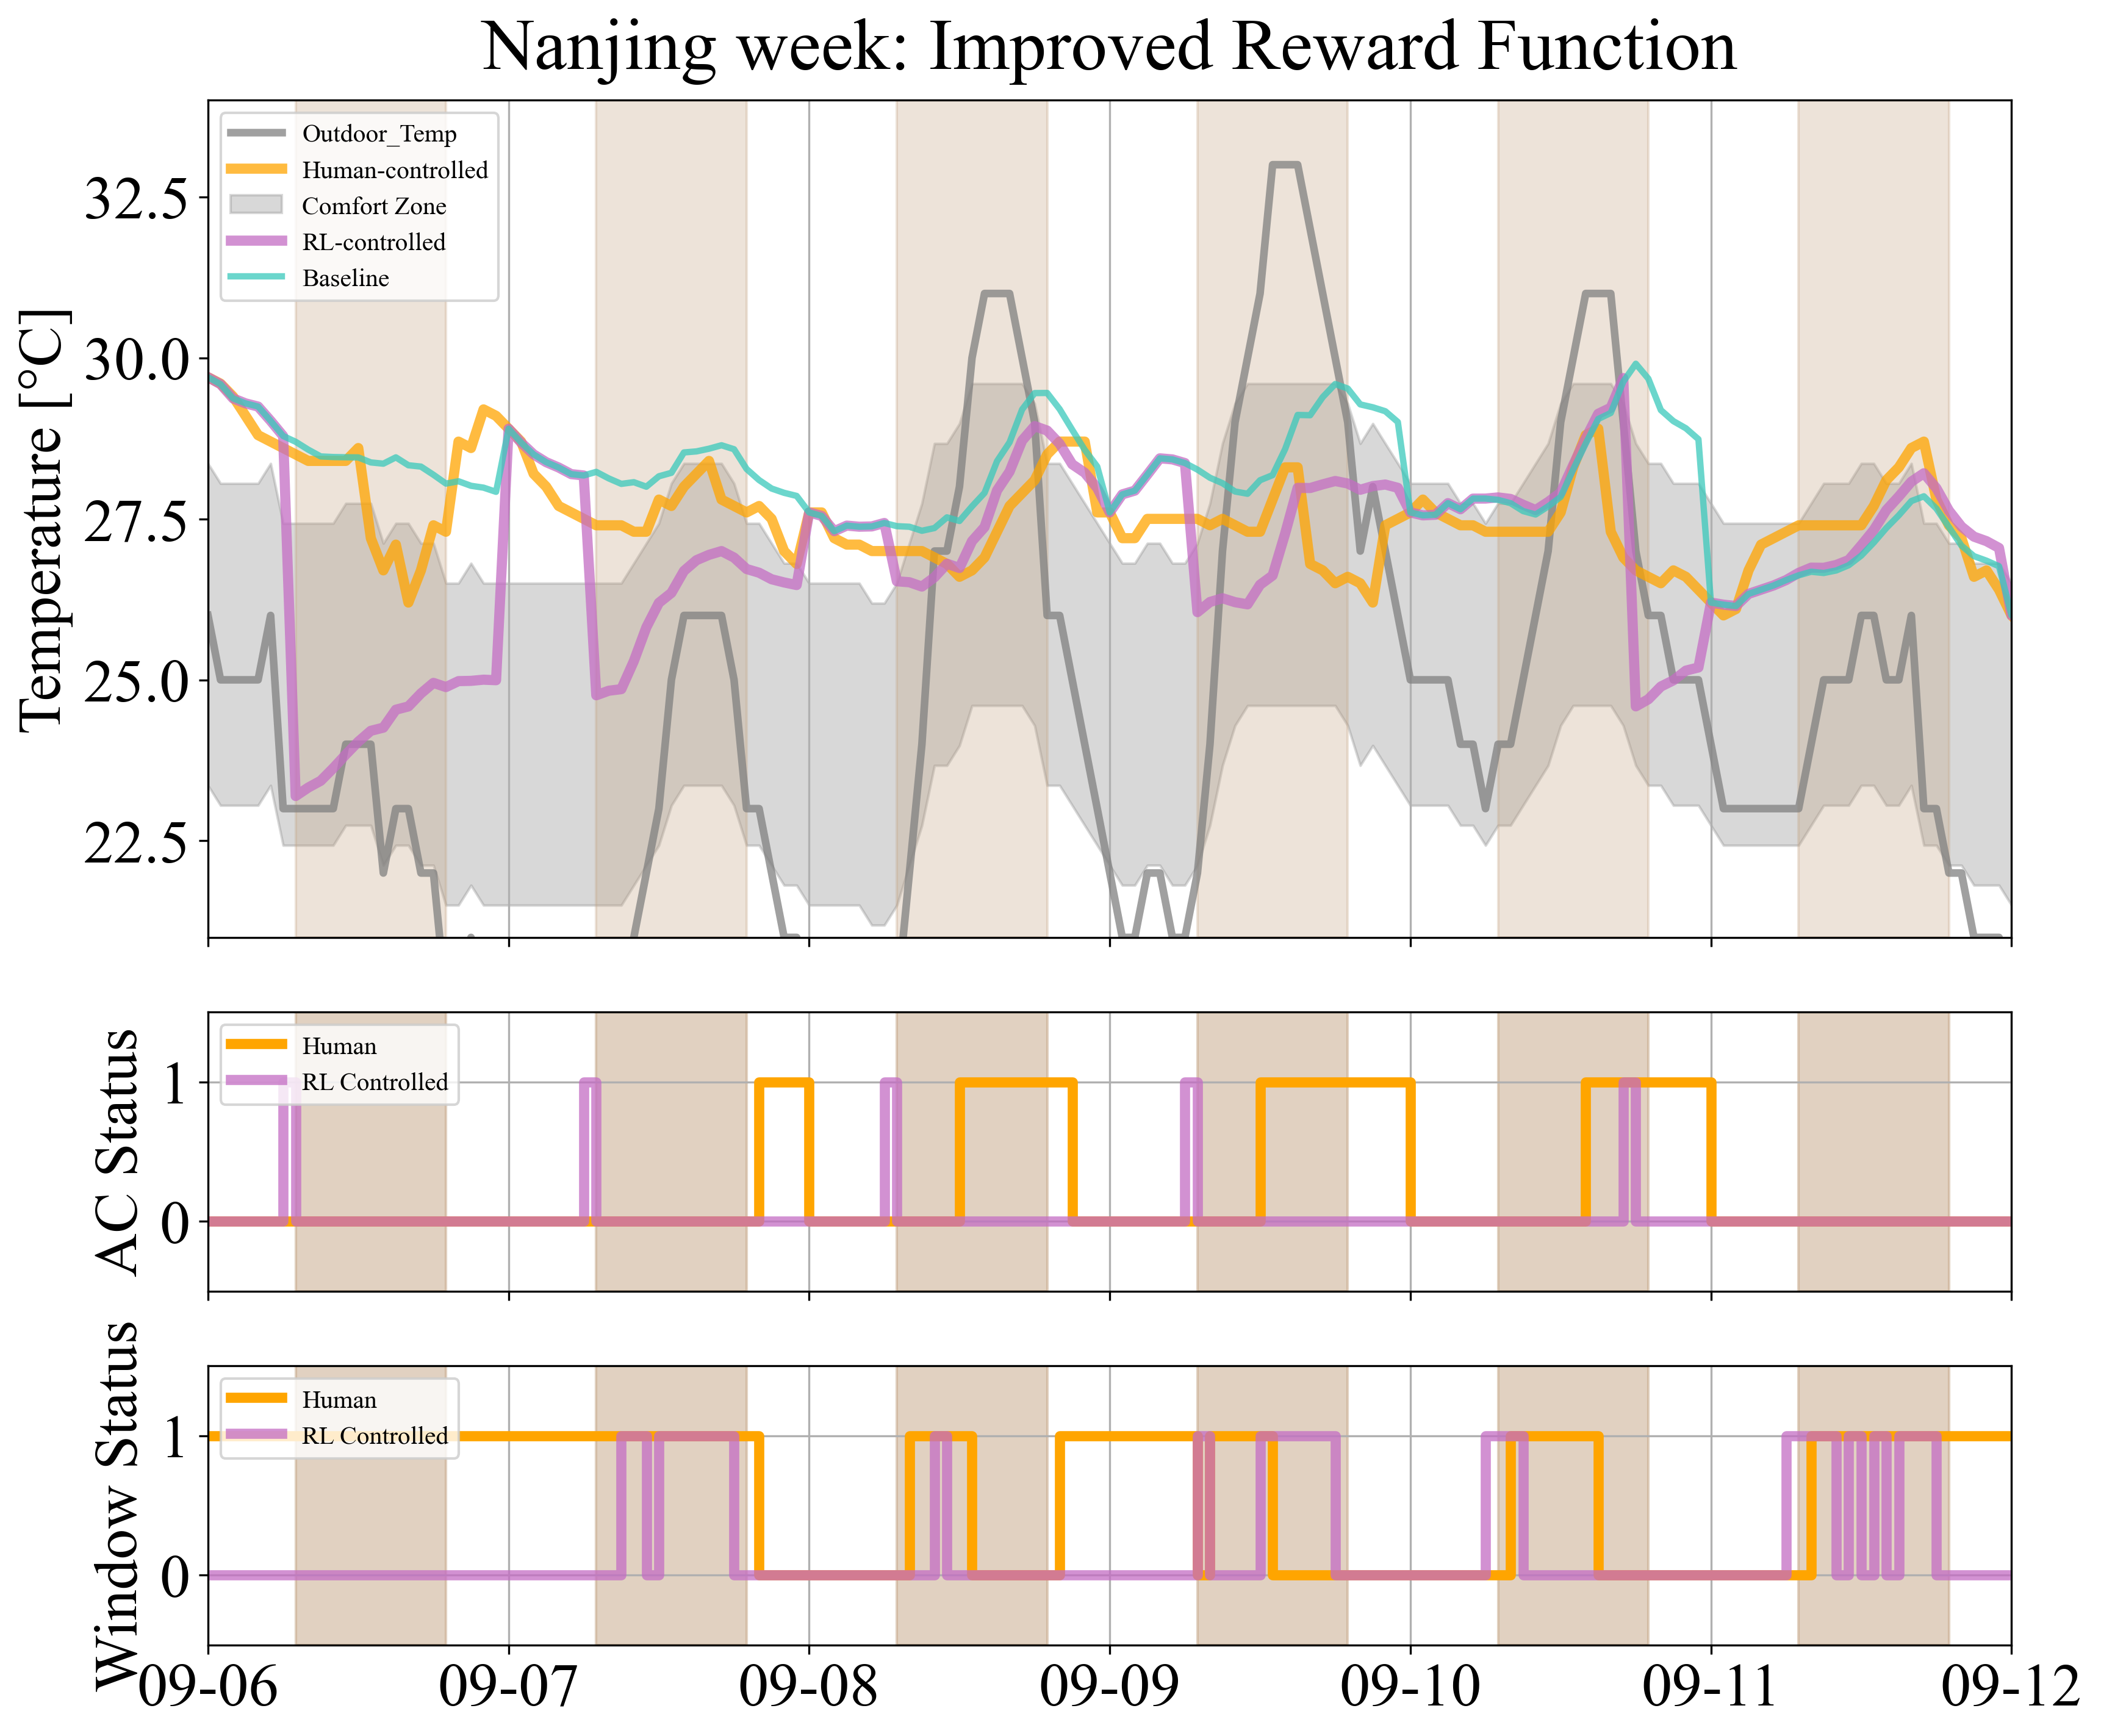

In [54]:
plot_result_policy(nanging_data_week, best_policy_AC_Status_List, best_policy_W_Status_List, best_policy_next_in_temp_list, "Nanjing", "Improved Reward Function", *city_dates_mapping["Nanjing"], nanjing_baseline_next_in_temp)

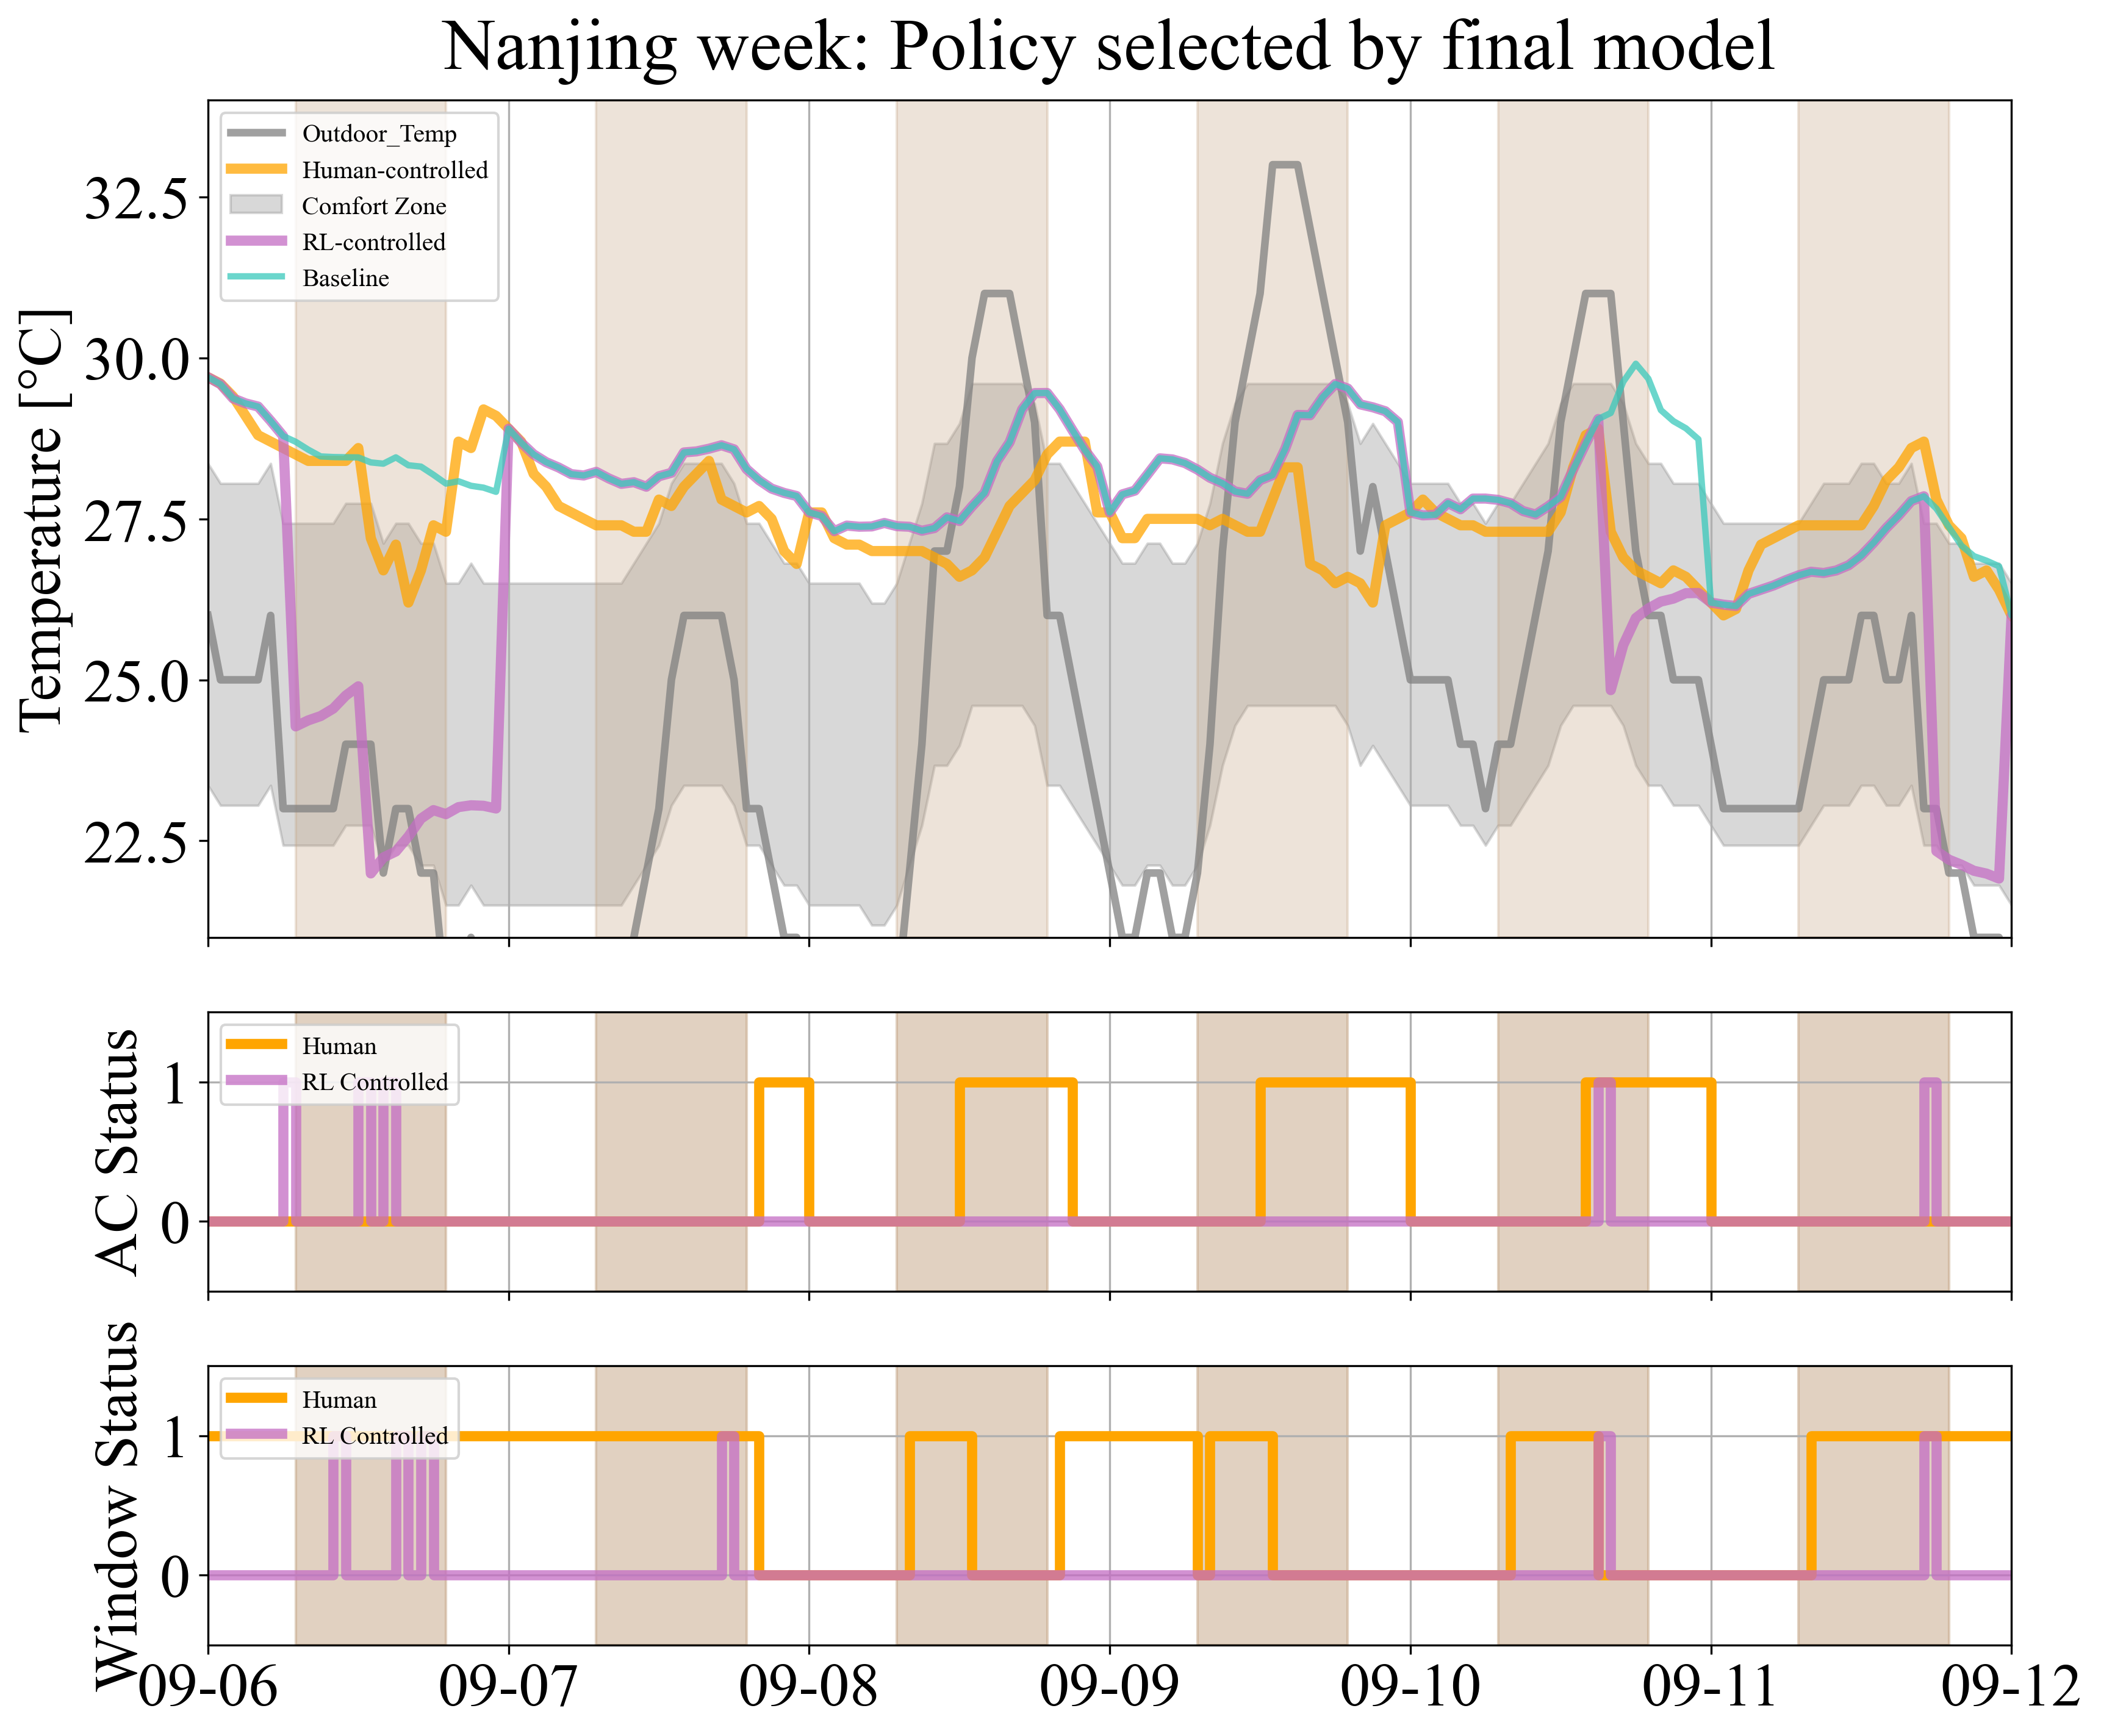

In [44]:
plot_result_policy(nanging_data_week, AC_Status_List_final_model, W_Status_List_final_model, next_in_temp_list_final_model, "Nanjing", "Policy selected by final model", *city_dates_mapping["Nanjing"], nanjing_baseline_next_in_temp)

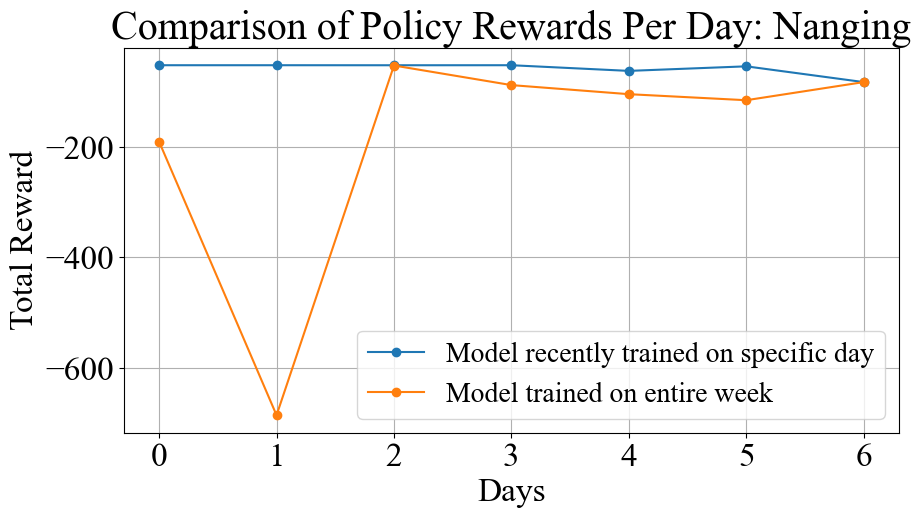

In [38]:
# Days of the week represented as numbers

def plot_comparison_of_policies_total_reward_per_day(policy_1_reward_list, policy_2_reward_list, city):
    days = list(range(0, 7)) 

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(days, policy_1_reward_list, 'o-', label='Model recently trained on specific day')
    plt.plot(days, policy_2_reward_list, 'o-', label='Model trained on entire week')

    # Adding titles and labels
    plt.title(f"Comparison of Policy Rewards Per Day: {city}")
    plt.xlabel("Days")
    plt.ylabel("Total Reward")

    # Adding a legend
    plt.legend(fontsize="small")

    # Display the plot
    plt.grid(True)
    plt.xticks(days)  # Ensure all days are displayed on x-axis
    plt.show()

plot_comparison_of_policies_total_reward_per_day(best_policy_total_reward_list, best_policy_reward_list_final_model, "Nanging")

## 9 Improve Reward Function

train a different model, using improved reward, aiming for a better policy

In [46]:
# Define Reward Function
def calculate_improved_reward(state, step, action, next_state, energy_weight=1):
    reward = 0
    standard = 'ASHRAE'
    coordinates_dict = {'ASHRAE': [[17.4, 18.4, 23.4, 24.4], [23.6, 24.6, 29.6, 30.6], [10, 30]]}
    L11, L12, U12, U11 = coordinates_dict[standard][0]
    L21, L22, U22, U21 = coordinates_dict[standard][1]
    T1, T2 = coordinates_dict[standard][2]
    InT, OutT = next_state[0], next_state[2]
    if OutT <= T1:
        L1, L2, U2, U1 = L11, L12, U12, U11
    elif OutT >= T2:
        L1, L2, U2, U1 = L21, L22, U22, U21
    else:
        increase = (OutT-T1)*(L21-L11)/(T2-T1)
        L1, L2, U2, U1 = L11+increase, L12+increase, U12+increase, U11+increase

    mid_range = (L2 + U2) / 2
    if InT>=L2 and InT<=U2:
        reward = 0
    elif InT<L2:
        reward = -60 * ((InT-mid_range) ** 2)
    elif InT>U2:
        reward = -60 * ((InT-mid_range) ** 2)
    if action==0 or action==12:
        reward = reward+0
    elif action>12:
        reward = reward-(2*(60*0.87*1)*energy_weight)
    else:
        reward = reward-((60*0.87*1)*energy_weight)
    return reward
    

In [47]:
episode_list = []
training_total_reward_list = []
best_policy = []
best_policy_next_in_temp_list = []
best_policy_AC_Status_List=[]
best_policy_W_Status_List=[]
best_policy_total_reward_list = []

data_RL = nanging_data_week # pd.concat([nanging_data_week, rende_data_week, flori_data_week, sau_paulo_data_week], ignore_index=True)

# Define Parameters
# 定义参数
num_features = 8
num_actions = 24
gamma = 0.9  # Discount factor 折扣因子
epsilon = 1.0  # Initial exploration rate 初始探索率
min_epsilon = 0.1  # Minimum exploration rate 最小探索率
epsilon_decay = 0.995  # Exploration rate decay factor 探索率衰减因子，ε-greedy策略中的ε
learning_rate = 0.001  # Learning rate 学习率，通常选择0.001有利于收敛
memory_capacity = 10000  # Experience replay buffer capacity 经验回放缓冲区容量
batch_size = 32  # Batch size 批量处理大小

# Create Q-Network and Target Network
Q_network = DQN(num_actions)
target_network = DQN(num_actions)

# Define Loss Function and Optimizer
loss_function = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.Adam(learning_rate)

for i in range(0,7):
    
    # Create Experience Replay Buffer
    replay_buffer = ReplayBuffer(memory_capacity)
    epsilon = 1.0  # Initial exploration rate per day 初始探索率

    # Train DQN
    data_test,xgboost_test = choose_data(i*24,data_RL)
    num_episodes = 1000
    for episode in range(num_episodes):
        episode_list.append(episode)
        data_pre_test = data_test
        xgboost_pre_test = xgboost_test
        total_reward = 0
        for step in range(6):
            xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        state = data_pre_test.iloc[6, :num_features].values  # 开始工作的初始始状态   
        for step in range(6,18):
            action = epsilon_greedy_policy(state, epsilon, num_actions, Q_network)
            Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
            xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
            xgboost_pre_test.at[step,'AC_Status'] = AC_Status
            xgboost_pre_test.at[step,'Window_Status'] = Window_Status
            xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
            xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
            if CLast_Time > 0:
                xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
            else:
                xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
            if WLast_Time > 0:
                xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
            else:
                xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_state = data_pre_test.iloc[step+1, :num_features].values           
            reward = calculate_improved_reward(state,step, action, next_state)
            total_reward += reward
            replay_buffer.push(state, action, next_state, reward)
            state = next_state
            if epsilon > min_epsilon:
                    epsilon *= epsilon_decay
            if len(replay_buffer.memory) >= batch_size:
                update_Q_network(batch_size, replay_buffer, Q_network, gamma, num_actions, loss_function, optimizer)
        training_total_reward_list.append(total_reward)
        
    # Training Completed, Make Decisions    
    data_pre_test = data_test
    xgboost_pre_test = xgboost_test
    total_best_policy_reward = 0
    for step in range(0,6):
        if step ==0:
            temp_original = data_pre_test.iloc[step]['Indoor_Temp']
            best_policy_next_in_temp_list.append(temp_original)
        best_policy.append(0)
        best_policy_AC_Status_List.append(0)
        best_policy_W_Status_List.append(0)
        xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
        hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
        next_differ_temp_list = model_XGB.predict(hour_row_df) 
        next_differ_temp = next_differ_temp_list[0]
        next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
        xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        best_policy_next_in_temp_list.append(next_in_temp)
        data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
    state = data_pre_test.iloc[6, :num_features].values
    for step in range(6,18):
        action = epsilon_greedy_policy(state, 0, num_actions, Q_network)
        Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
        best_policy.append(action)
        best_policy_AC_Status_List.append(AC_Status)
        best_policy_W_Status_List.append(Window_Status)
        xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
        xgboost_pre_test.at[step,'AC_Status'] = AC_Status
        xgboost_pre_test.at[step,'Window_Status'] = Window_Status
        xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
        xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
        if CLast_Time > 0:
            xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
        else:
            xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
        if WLast_Time > 0:
            xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
        else:
            xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
        hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
        next_differ_temp_list = model_XGB.predict(hour_row_df) 
        next_differ_temp = next_differ_temp_list[0]
        next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
        xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        best_policy_next_in_temp_list.append(next_in_temp)
        data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        next_state = data_pre_test.iloc[step+1, :num_features].values
        reward = calculate_improved_reward(state,step, action, next_state)
        total_best_policy_reward += reward      
        state = next_state
    for step in range(18,23):
        best_policy.append(0)
        best_policy_AC_Status_List.append(0)
        best_policy_W_Status_List.append(0)
        xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
        hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
        next_differ_temp_list = model_XGB.predict(hour_row_df) 
        next_differ_temp = next_differ_temp_list[0]
        next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
        xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        best_policy_next_in_temp_list.append(next_in_temp)
        data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
    best_policy.append(0)  
    best_policy_AC_Status_List.append(0)
    best_policy_W_Status_List.append(0)
    best_policy_total_reward_list.append(total_best_policy_reward)  
    
    print(best_policy[(i)*24:(i+1)*24])
    print(best_policy_next_in_temp_list[(i)*24:(i+1)*24])

[0, 0, 0, 0, 0, 0, 3, 3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[29.7, 29.59164111763239, 29.371042688190936, 29.29376123547554, 29.244282887130975, 29.022986785322427, 28.7867736376822, 24.871895269304513, 23.97866894379258, 24.095425718277692, 24.22452754601836, 24.38439846858382, 24.54192756935954, 24.681202956289052, 24.74023540765047, 25.042990167438983, 25.096746277809142, 25.28948692679405, 25.404864025115966, 25.374962058663368, 25.4900448217988, 25.490887014882173, 25.51448439316591, 25.500492455193307]
[0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[28.9, 28.684399569034575, 28.50103864967823, 28.380494908988474, 28.29739218354225, 28.19477899521589, 28.173810362443326, 24.76028048954904, 23.987338184937833, 23.997871129401027, 24.43381473291665, 24.95093300808221, 25.374272076971828, 25.573726682551204, 25.97812023628503, 26.094774930365382, 26.283662690408526, 26.484670041687785, 26.522453664429484, 26.36959250140935, 26.321526928432284, 

In [48]:
description = "Improved Reward Calculation. Nanjing sample data week. 1000 episodes per day. all parameters are default"
save_experiment_results("nanjing_sample_week_improved_reward", Q_network, training_total_reward_list, best_policy, best_policy_next_in_temp_list, best_policy_AC_Status_List, best_policy_W_Status_List, best_policy_total_reward_list, description)

Results saved in directory: results_nanjing_sample_week_improved_reward


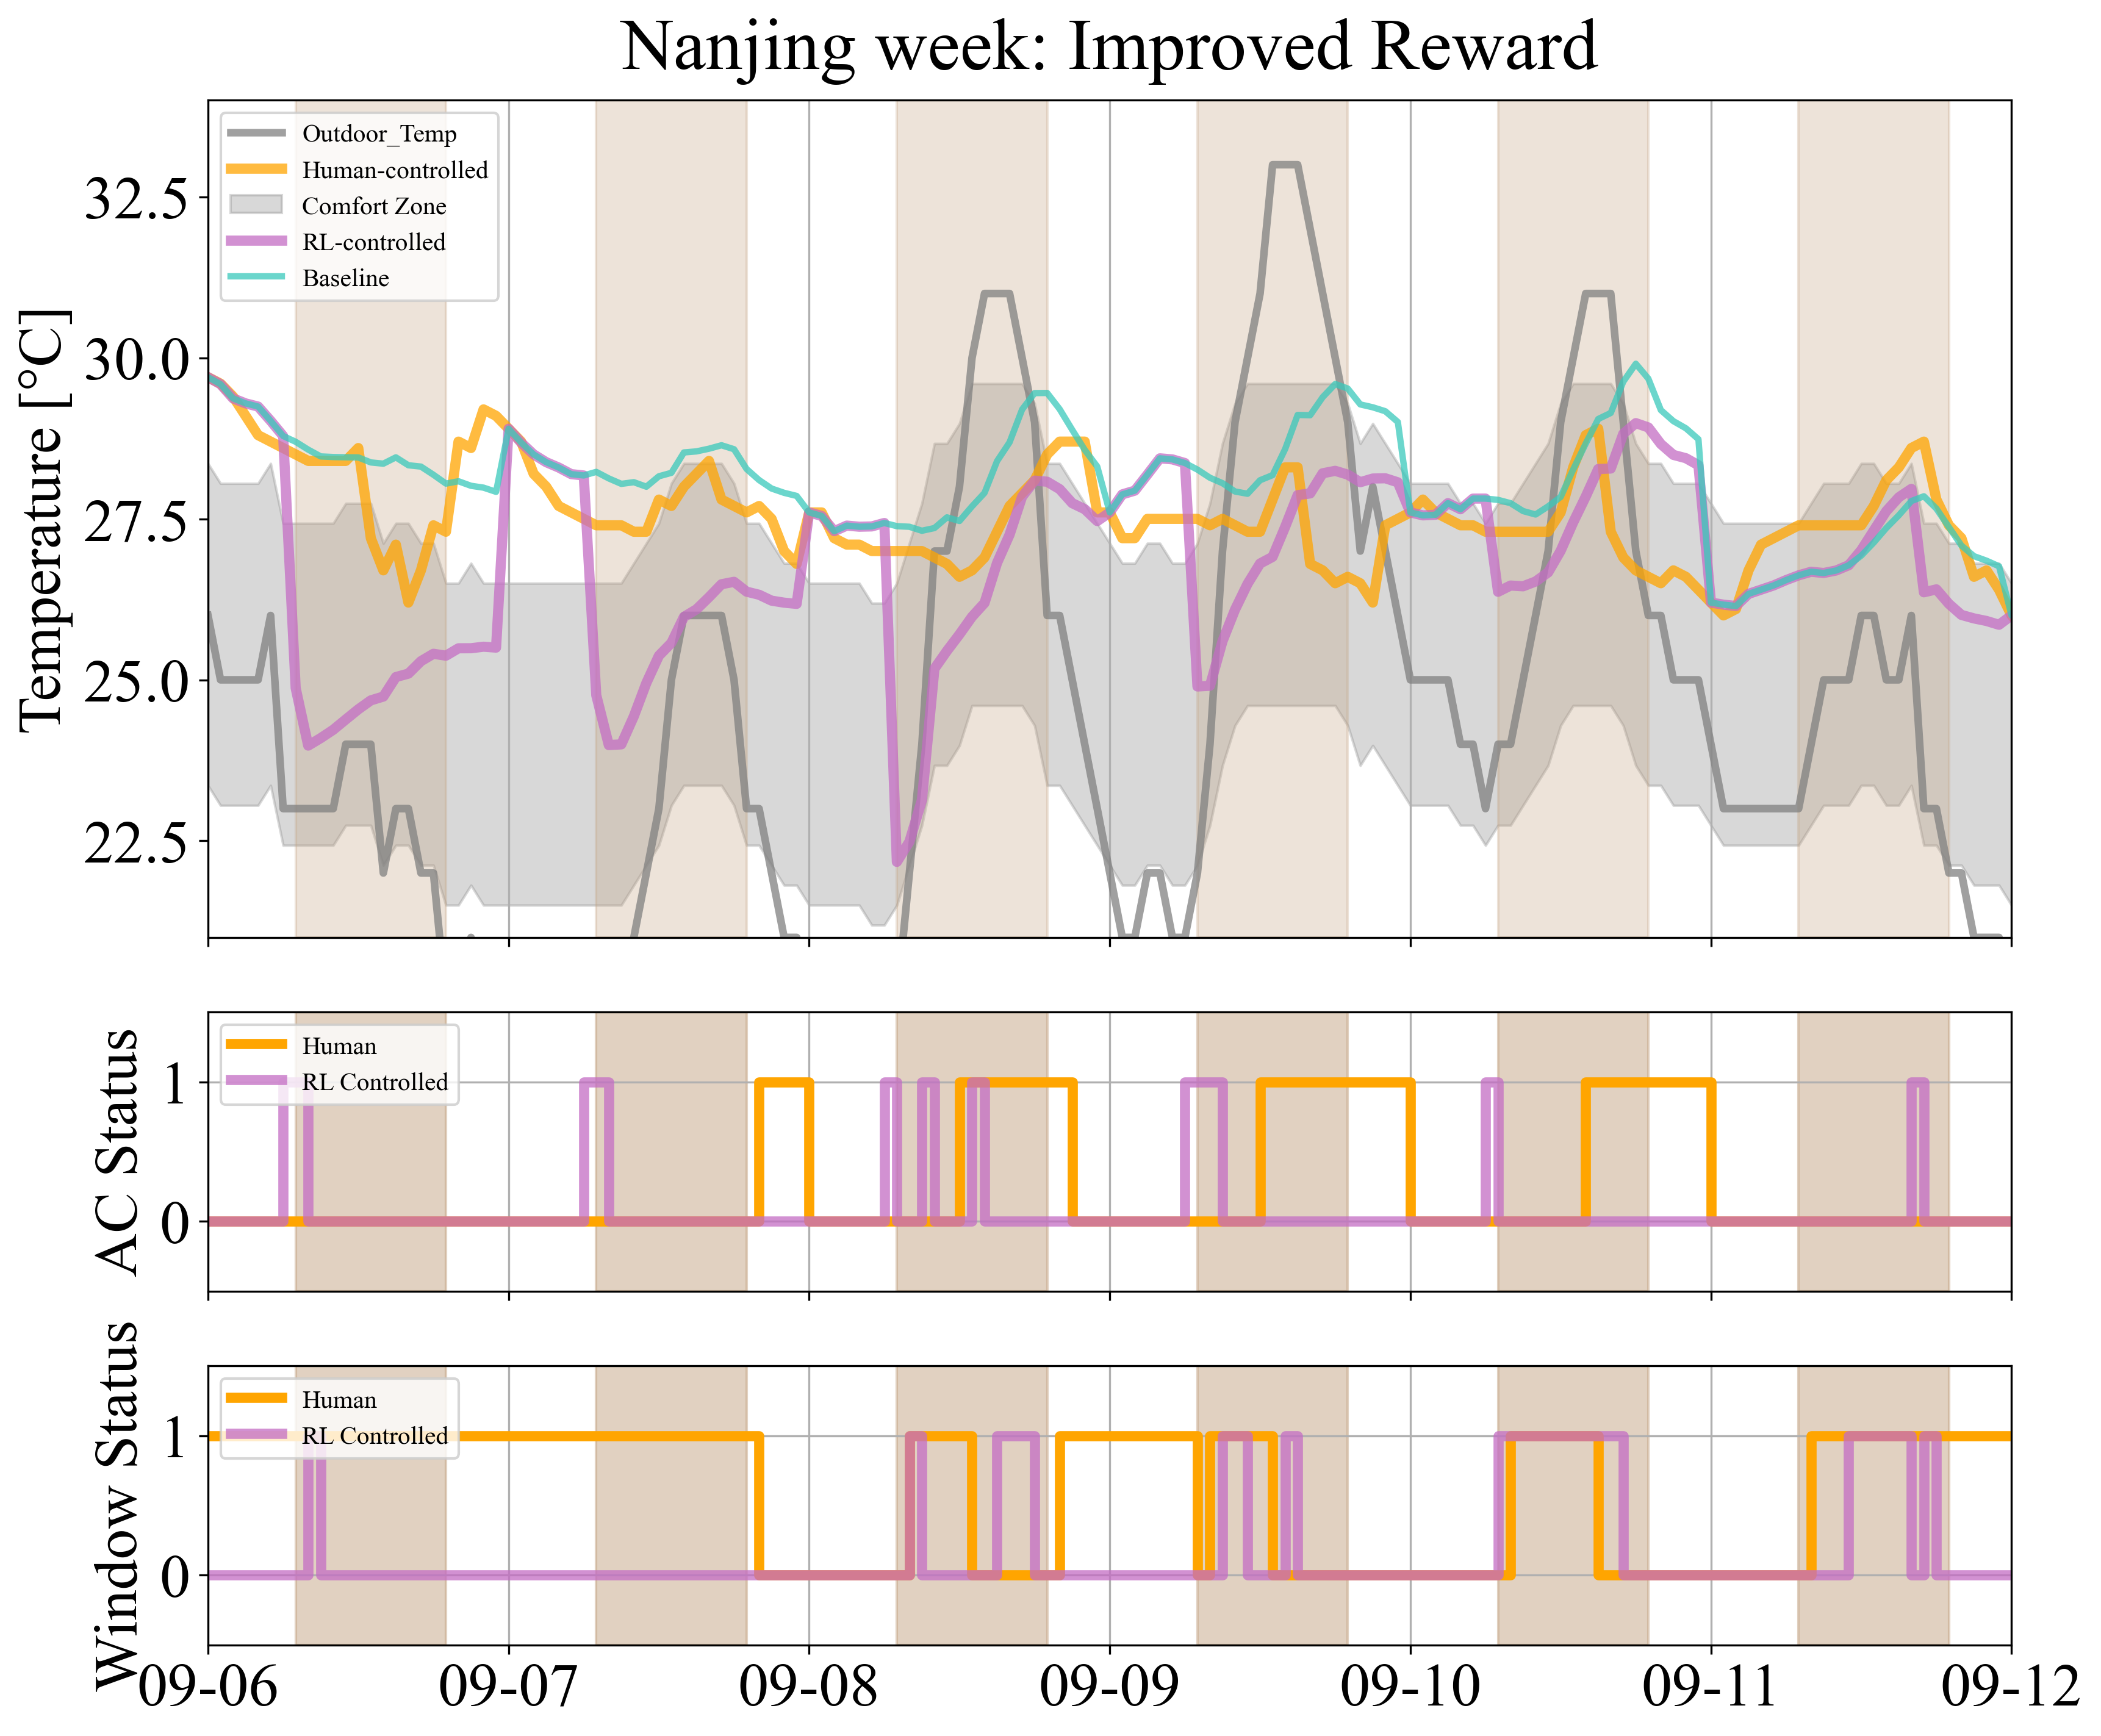

In [49]:
plot_result_policy(nanging_data_week, best_policy_AC_Status_List, best_policy_W_Status_List, best_policy_next_in_temp_list, "Nanjing", "Improved Reward", *city_dates_mapping["Nanjing"], nanjing_baseline_next_in_temp)